In [2]:
import os
import cv2
from scipy import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fracture
import DIC as dic

#csv파일 형식 바꾸기!

"""setting values"""
path = r'E:\experiment data\aluminum\2021-03-25\faruv_tension_2\img'
path_save= r'E:\experiment data\aluminum\2021-03-25\faruv_tension_2'

slice_x1 = 71
slice_x2 = 142
slice_y1 = 414
slice_y2 = 661

file_list = os.listdir(path)
count = 0
result = []

for file in file_list:
    if file.endswith(".jpg"):
        im = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)
        im_calculate = np.array(im)
        img_box = im_calculate[slice_y1:slice_y2, slice_x1:slice_x2]

        ave = np.average(img_box)
        result = np.append(result, [ave])
        count += 1

Run complete


In [3]:
ml_avg = result

from scipy.signal import savgol_filter
tension_data = np.array(pd.read_csv(path+'/tension.csv', encoding='CP949'))

time, strain, stress = tension_data[:, 0], tension_data[:, 4]*10/25, tension_data[:, 3]*3000/18
max_range = 16741
stress = savgol_filter(stress[0:max_range],201,1)
strain = savgol_filter(strain[0:max_range],201,1)
ml_avg = savgol_filter(ml_avg[0:max_range],6001,1)
time = time[0:max_range]

C:\Users\ghrms\Anaconda3\envs\pro\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\ghrms\Anaconda3\envs\pro\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


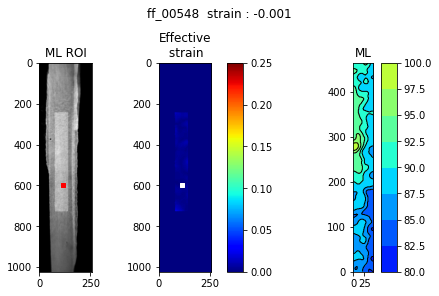

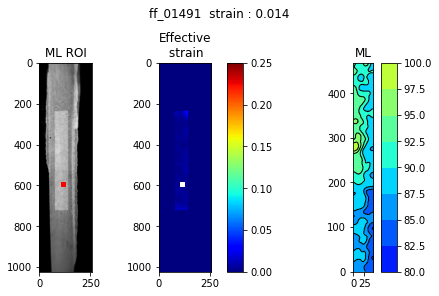

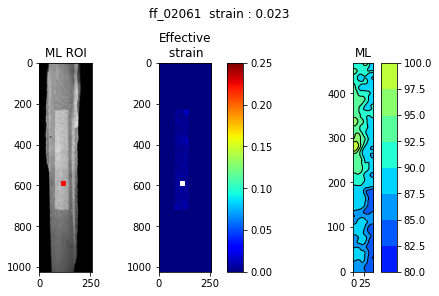

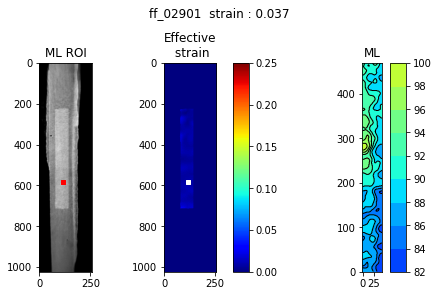

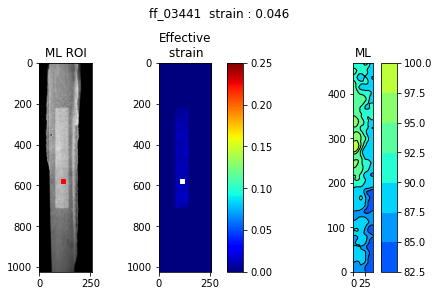

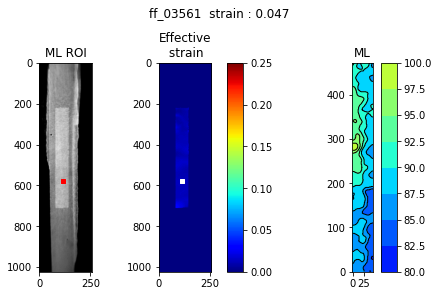

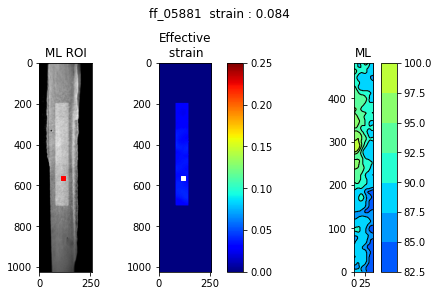

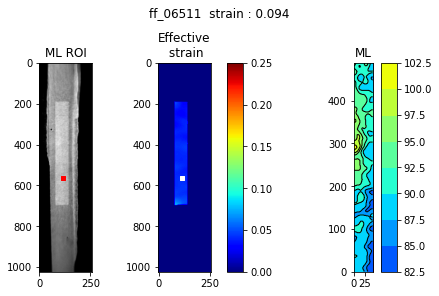

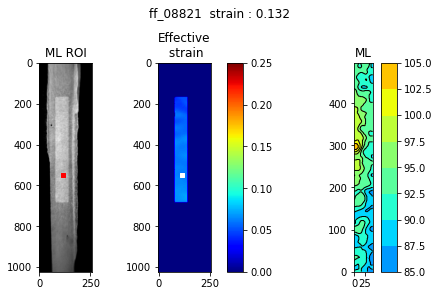

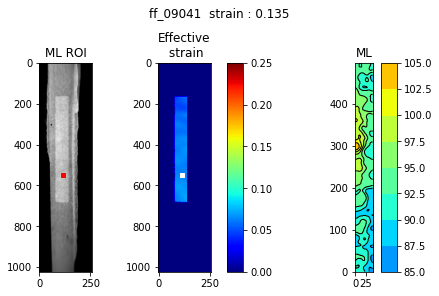

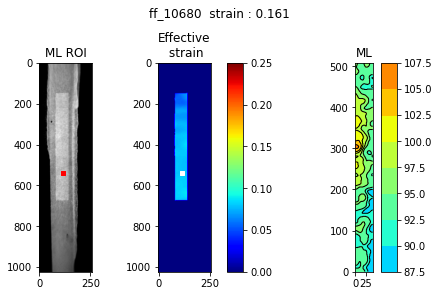

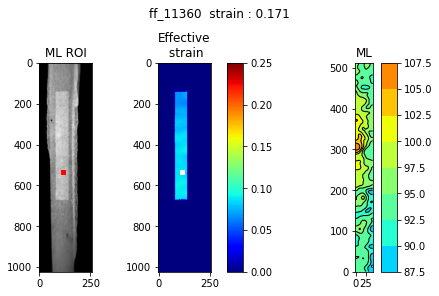

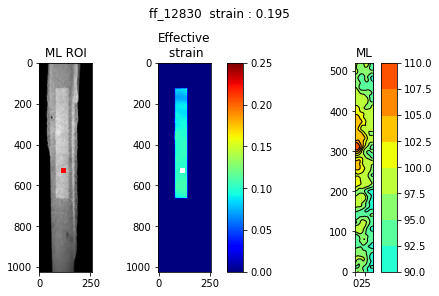

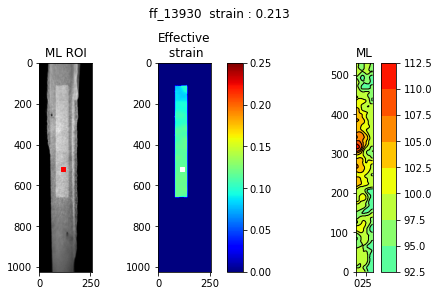

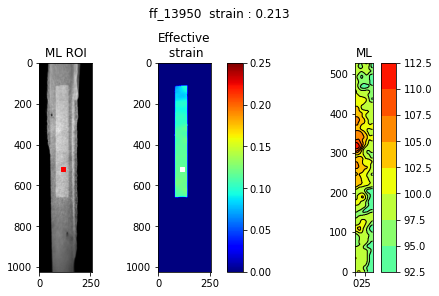

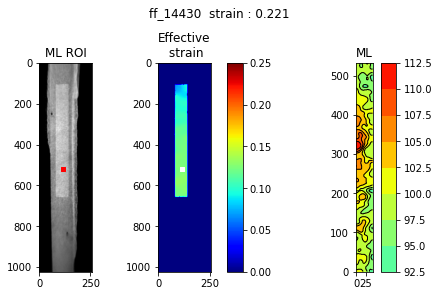

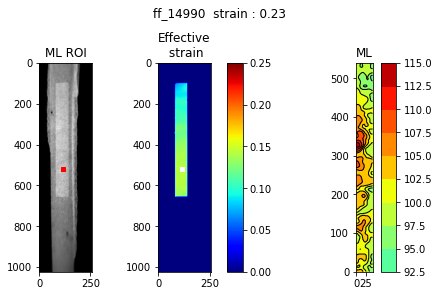

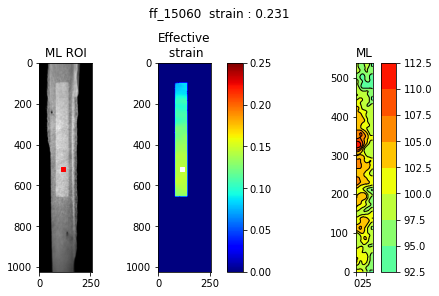

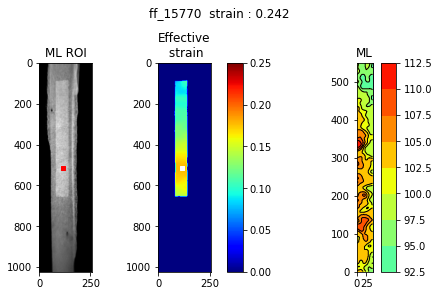

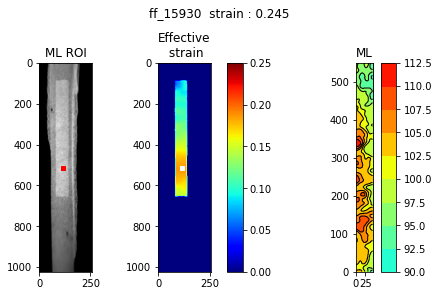

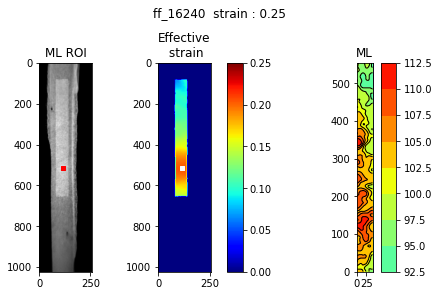

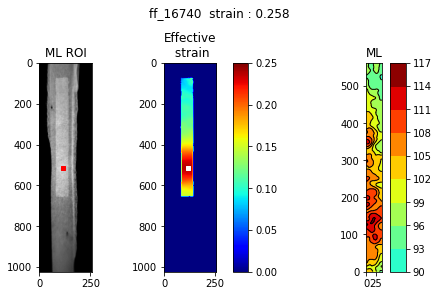

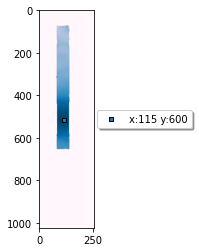

In [226]:


"""
Matlab코드 여러 Dic데이터있는경우
path = 'D:/faruv_tension_2/slectpic/data'

for i=1:1:22
uu=handles_ncorr.data_dic.displacements(i).plot_u_cur_formatted;
vv=handles_ncorr.data_dic.displacements(i).plot_v_cur_formatted;
exx=handles_ncorr.data_dic.strains(i).plot_exx_cur_formatted;
eyy=handles_ncorr.data_dic.strains(i).plot_eyy_cur_formatted;
exy=handles_ncorr.data_dic.strains(i).plot_exy_cur_formatted;

save([path,'/', num2str(i), '_exx', '.mat'],'exx')
save([path,'/', num2str(i), '_exy', '.mat'],'exy')
save([path,'/', num2str(i), '_eyy', '.mat'],'eyy')
save([path,'/', num2str(i), '_uu', '.mat'],'uu')
save([path,'/', num2str(i), '_vv', '.mat'],'vv')

end

"""

"""setting values"""
path = r'D:\faruv_tension_2\slectpic'
save_path =r'D:\faruv_tension_2\slectpic/output'
image = dic.load_file(path)

ref = image[list(image.keys())[0]]
# ref_x_list, ref_y_list = [115,116,115,110, 115,113,117,105], [600,400,500,450,380,400,630,650]
ref_x_list, ref_y_list = [115] , [600]
ratio = 0.04

ee_list = []
local_list_all=[]
local_list=[]
count = 0
for ref_x, ref_y in zip(ref_x_list, ref_y_list):
    for num in range(1,22+1):
        file_num = str(num)
        uu = io.loadmat(path+'/data/'+file_num+'_uu.mat')['uu']
        vv = io.loadmat(path+'/data/'+file_num+'_vv.mat')['vv']
        uu_resize = cv2.resize(uu,(0,0),fx=2, fy=2 )
        vv_resize = cv2.resize(vv,(0,0),fx=2, fy=2 )

        exx = io.loadmat(path+'/data/'+file_num+'_exx.mat')['exx']
        eyy = io.loadmat(path+'/data/'+file_num+'_eyy.mat')['eyy']
        exy = io.loadmat(path+'/data/'+file_num+'_exy.mat')['exy']
        ee = fracture.effective_strain(exx, eyy, exy)
        exx_resize = cv2.resize(exx,(0,0),fx=2, fy=2 )
        eyy_resize = cv2.resize(eyy,(0,0),fx=2, fy=2 )
        exy_resize = cv2.resize(eyy,(0,0),fx=2, fy=2 )
        ee_resize = cv2.resize(ee,(0,0),fx=2, fy=2 )

        ee_mask = np.where(ee_resize>0, 255, ee_resize*0).astype('uint8')
        ml_image = image[list(image.keys())[num]]
        mask_ml = dic.find_zone(cv2.copyTo(ml_image, ee_mask))[10:-10,10:-10]
        if num == 1:
            ref = dic.find_zone(cv2.copyTo(image[list(image.keys())[0]], ee_mask)[10:-10,10:-10])


        gas = cv2.GaussianBlur(mask_ml[:,:,1],(0,0),5)

        cur_y = np.round(ref_y+vv_resize[ref_y,ref_x]/ratio,1).astype('int')
        cur_x = np.round(ref_x+uu_resize[ref_y,ref_x]/ratio,1).astype('int')

        local_ee = np.average(ee_resize[cur_y-2 : cur_y+2 , cur_x-2: cur_x+2])
        local_ml = np.average(ml_image[cur_y-2 : cur_y+2 , cur_x-2: cur_x+2]) - np.average(ref[ref_y-2 : ref_y+2 , ref_x-2 : ref_x+2])
        local_list.append([local_ee,local_ml])


        #쓸려면 포인트 하나만
        fig, ax = plt.subplots(1, 3 , constrained_layout=True)
        fig.suptitle(list(image.keys())[num] +'  strain : ' + str(np.round(strain[int(list(image.keys())[num].split('_')[1])],3)))

        ax0 = ax[0].imshow(cv2.addWeighted(ml_image[:,:,2],1, ee_mask,0.06,-40),cmap='gray')
        ax[0].set_title('ML ROI')
        ax[0].scatter(cur_x, cur_y,color='red', marker='s', s=10)

        ax1 = ax[1].imshow(ee_resize, cmap='jet', vmin=0, vmax=0.25)
        ax[1].set_title('Effective\n strain')
        ax[1].scatter(cur_x, cur_y,color='white', marker='s', s=10)
        plt.colorbar(ax1,ax=ax[1])

        gas = cv2.flip(gas,0)
        ax[2].imshow(gas)
        ax2 = ax[2].contourf(gas,cmap='jet', vmin=75, vmax=116)
        ax3 = ax[2].contour(gas,colors='black',linewidths=1)
        ax[2].invert_yaxis()
        plt.colorbar(ax2, ax=ax[2])
        # ax[2].axis('off')
        ax[2].set_title('ML')

        ee_list.append([strain[int(list(image.keys())[num].split('_')[1])], np.max(dic.find_zone(ee_resize)), np.max(mask_ml[:,:,1])-np.max(ref),list(image.keys())[num].split('_')[1]])

        # plt.savefig(save_path+'/'+list(image.keys())[num]+'.png', dpi=300)
        plt.show()
        plt.close()

    plt.imshow(ee_resize, cmap='PuBu', vmin=0, vmax=0.25)
    plt.scatter(cur_x, cur_y, marker='s', s=10  ,label='x:'+str(ref_x_list[count]) + ' y:'+str(ref_y_list[count]), edgecolors='black')
    plt.legend()
    local_list_all.append(local_list)
    local_list = []
    count+=1
plt.legend(loc='center right', bbox_to_anchor=(2.9, 0.5), fancybox=True, shadow=True)
# plt.savefig(save_path+'/국부 점으로찍은위치.png', dpi=300)

In [ ]:
fig, ax1 = plt.subplots()
fig.subplots_adjust()
count = 0

for _ in local_list_all:
    ax1.scatter(np.array(local_list_all)[count][:,0], np.array(local_list_all)[count][:,1], label='x:'+str(ref_x_list[count]) + ' y:'+str(ref_y_list[count]), marker='X')
    count +=1
    ax1.legend(loc='center right', bbox_to_anchor=(1.2, 0.4), fancybox=True, shadow=True)
ax1.set_ylabel('ml')
ax1.set_xlabel('effective_strain')
ax1.grid()
ax1.set_title('Local effective strain vs Local ML intensity')
# plt.savefig(save_path+'/국부 점으로찍은위치그래프.png', dpi=300, bbox_inches='tight',  pad_inches=0)




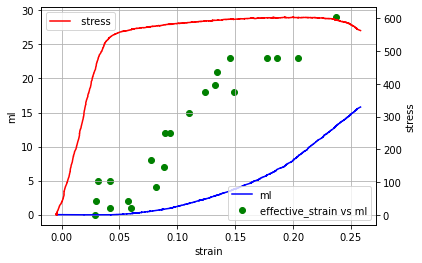

In [227]:
"""평균"""

fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.set_xlabel('strain')
ax.set_ylabel('ml')
ax1.set_ylabel('stress')
line1 = ax.plot(strain, ml_avg-ml_avg[0], color='b', label="ml")
line2 = ax1.plot(strain, stress, color='r', label=" stress")
scatter1 = ax.scatter(np.array(ee_list)[:,1].astype('float'), np.array(ee_list)[:,2].astype('float'), color = 'green', label='effective_strain vs ml')
ax.plot()

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(loc = 4)

ax1.legend(loc = 2)
ax.grid()
fig.savefig(save_path+'/맥스ml_맥스dicgraph1.png', dpi = 300)
plt.show()
plt.close()

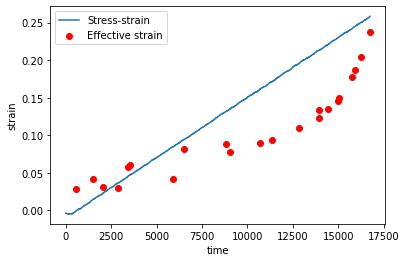

In [228]:
plt.plot(time,strain, label='Stress-strain')
plt.scatter(np.array(ee_list)[:,3].astype('uint'), np.array(ee_list)[:,1].astype('float'), label='Effective strain', color='red')
plt.xlabel('time')
plt.ylabel('strain')
plt.legend()

plt.savefig(save_path+'/맥스ml_맥스dic1graph1.png', dpi = 300)
plt.show()